## Project Group - 31

Members (student number): 
- Gijs de Werd          (4717775)
- Georges Puttaert      (4686160)
- Thijs Roolvink        (4961382)
- Jim van Oosten        (4734998)

A link to the Github Repository: https://github.com/jimvanoosten/TIL6022_Group31

## Contribution Statement

**Gijs de Werd**: Setting up project and doing the Data analysis, coding data preparation

**Georges Puttaert**: Visualization general plots and coding of the data

**Thijs Roolvink**: Conceptualization, coding of the in depth plots

**Jim van Oosten**: Background research, coding conclusion 

## Research Objective

**Hypotheses**: 

The hypothesis is that lower income classes can be very depended on flight with passengers and tourism and that gdp is dependent on these factors, high income classes less.

**Main question**: 

"From 2010 to 2020, how did variations in flight volume, GDP growth, and tourism number interrelate, and can these trends reveal economic resilience patterns or unexpected behaviors among countries categorized by income class?"

**Sub questions**:
- 1: How are income classes currently determined, and which countries serve as typical examples for each class?

- 2: Does holistic clustering of countries based on flight volume, GDP growth, and tourism revenue reveal tangible differences between the predefined income classes?

- 3: Among the variables of flight volume, GDP growth, and tourism revenue, which has the most significant influence on a country's classification within an income class

- 4: Are the numbers of flights and tourism a decent consideration to determine the income class of a country by gdp? Eventually, with Kmeans, a clustering is done to check of there is indeed correlation 

some answers:
- *The clustering algorithm can cluster countries based on these factors*
- *There can be seen that luxembourg do not care if lower passengers or tourism, gdp still stays high*
- *The lower income countries can be determined with the kmeans and there can be seen that Italy, Spain, France and Germany indeed need tourism and passengers, can be clearly seen*
- *AT, BE, DK, FI, LU, NL, SE: These are high income classes and are clustered together based on the criteria.*


## Data Used

GDP per capita, quarterly data to monthly: https://ec.europa.eu/eurostat/databrowser/view/namq_10_gdp/default/table?lang=en \
Commercial flights by reporting airport – monthly data: https://ec.europa.eu/eurostat/databrowser/view/avia_paoc__custom_7863778/default/line?lang=en \
Arrivals at tourist accommodation establishments - monthly data: https://ec.europa.eu/eurostat/databrowser/product/view/tour_occ_nim \

## Data Pipeline

## 1. Introduction

From the year 2010 to 2020, the aviation sector showed a rapid increase in air passengers and the tourism sector flourished influencing the global GDP. Countries in the EU are influenced by the number fluctuations regarding the air passengers, tourism, and GDP per capita. Where lower-income countries are being more vulnarable to disruuotions in air passengers and tourism, whereas higher income countries tend be more resilient. Countries as Italy and Spain depend highly on air passengers and tourism. This study aims to deep dive into the interrealtion between the three factors in the EU countries. Using data from a decade before the COVID-19 pandamic, since biased results are generated. Throughout data analysis and unsupervised clustering methods, pattern are uncovered highlighting the economic behaviors of countries in response to air passengers, tourism and GDP. The EU countries are clustered based on these pattern are will show significant interrelations which can be linked to the social and income class of a country. 



## 2. Data preperation

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import scipy.stats as stats
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [30]:
traffic = pd.read_csv('Datasets/air_passengers_from2000.csv')
tourism = pd.read_csv('Datasets/tourism_from2000.csv')
gdp = pd.read_csv('Datasets/gdp_from2000.csv')

In [31]:
def quarter_to_month(quarter):
    year, qtr = quarter.split('-')
    if qtr == 'Q1':
        return [f'{year}-01', f'{year}-02', f'{year}-03']
    elif qtr == 'Q2':
        return [f'{year}-04', f'{year}-05', f'{year}-06']
    elif qtr == 'Q3':
        return [f'{year}-07', f'{year}-08', f'{year}-09']
    else: # 'Q4'
        return [f'{year}-10', f'{year}-11', f'{year}-12']

mask = gdp['TIME_PERIOD'].str.match(r'\d{4}-Q[1-4]$')
gdp.loc[mask, 'TIME_PERIOD'] = gdp.loc[mask, 'TIME_PERIOD'].apply(quarter_to_month)
gdp = gdp.explode('TIME_PERIOD')

In [32]:
# Make a database 
traffic = traffic.rename(columns={'OBS_VALUE': 'Traffic'})
tourism = tourism.rename(columns={'OBS_VALUE': 'Tourism'})
gdp = gdp.rename(columns={'OBS_VALUE': 'GDP'})


traffic_filtered = traffic[
    (traffic['tra_meas'] == 'PAS_BRD') &
    (traffic['TIME_PERIOD'] >= '2010-01') & 
    (traffic['TIME_PERIOD'] <= '2020-01')                   
]

tourism_filtered = tourism[
    (tourism['unit'] == 'NR') &
    (tourism['nace_r2'] == 'I551') &
    (tourism['c_resid'] == 'TOTAL') &
    (tourism['TIME_PERIOD'] >= '2010-01') &
    (tourism['TIME_PERIOD'] <= '2020-01')
]

gdp_filtered = gdp[
    (gdp['unit'] == 'CP_EUR_HAB') &
    (gdp['s_adj'] == 'NSA') &
    (gdp['na_item'] == 'B1GQ') &
    (gdp['TIME_PERIOD'] >= '2010-01') &
    (gdp['TIME_PERIOD'] <= '2020-01')
]

In [33]:
# Merge the dataset into 1 big dataset
countries = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "EL", "ES", "FI", "FR", "HR", "HU", 'UK', "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]

traffic_filtered = traffic_filtered[traffic_filtered['geo'].isin(countries)]
tourism_filtered = tourism_filtered[tourism_filtered['geo'].isin(countries)]
gdp_filtered = gdp_filtered[gdp_filtered['geo'].isin(countries)]


merged_data = pd.merge(traffic_filtered[['TIME_PERIOD', 'geo', 'Traffic']], 
                       gdp_filtered[['TIME_PERIOD', 'geo', 'GDP']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

merged_data = pd.merge(merged_data,
                       tourism_filtered[['TIME_PERIOD', 'geo', 'Tourism']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

In [34]:
# Check if there are Nan values
# nan_rows = merged_data[merged_data.isna().any(axis=1)]
# print(nan_rows)

## 3. Visualization

### Time series interactive dashboard, default option is no country

In [35]:
merged_data = merged_data.sort_values(by=['geo', 'TIME_PERIOD'])

fig = go.Figure()

# Scatter for Traffic
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['Traffic'],
        mode='lines',
        name=f"Traffic {country}",
        visible="legendonly"
    ))

# Scatter forTourism
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['Tourism'],
        mode='lines',
        name=f"Tourism {country}",
        visible="legendonly"
    ))

# Scatter for GDP
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['GDP'],
        mode='lines',
        name=f"GDP {country}",
        yaxis="y2",  
        visible="legendonly"
    ))

fig.update_layout(
    title='Traffic, Tourism, and GDP (2010-2022)',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Traffic/Tourism Value'),
    yaxis2=dict(title='GDP Value', overlaying='y', side='right', title_standoff=25), 
    showlegend=True,
    legend=dict(x=1.05)
)

fig.show()


### Correlation heatmap interactive dashboard

for the correlation heatmap Dashboard, please visit:

http://127.0.0.1:8051/

## 4. Unsupervised learning: Kmeans clustering

In [36]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data[['Traffic','Tourism', 'GDP']])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

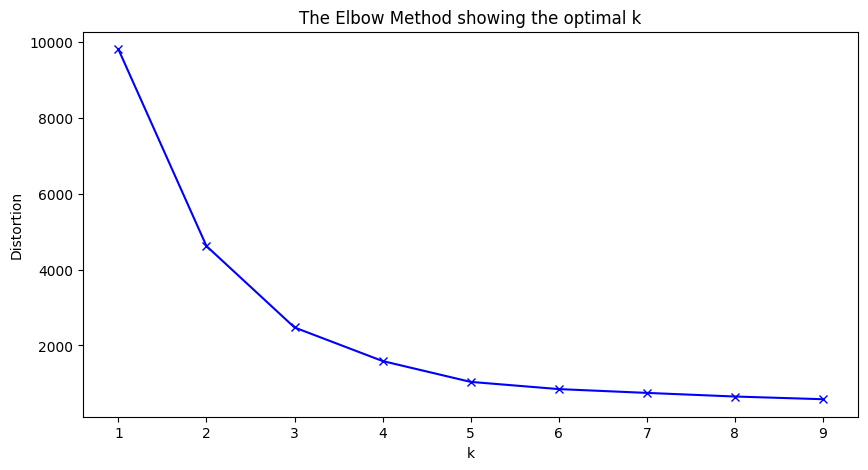

In [37]:
# Determine the number of clusters (using Elbow method as an example)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_data)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
merged_data['Cluster'] = clusters

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



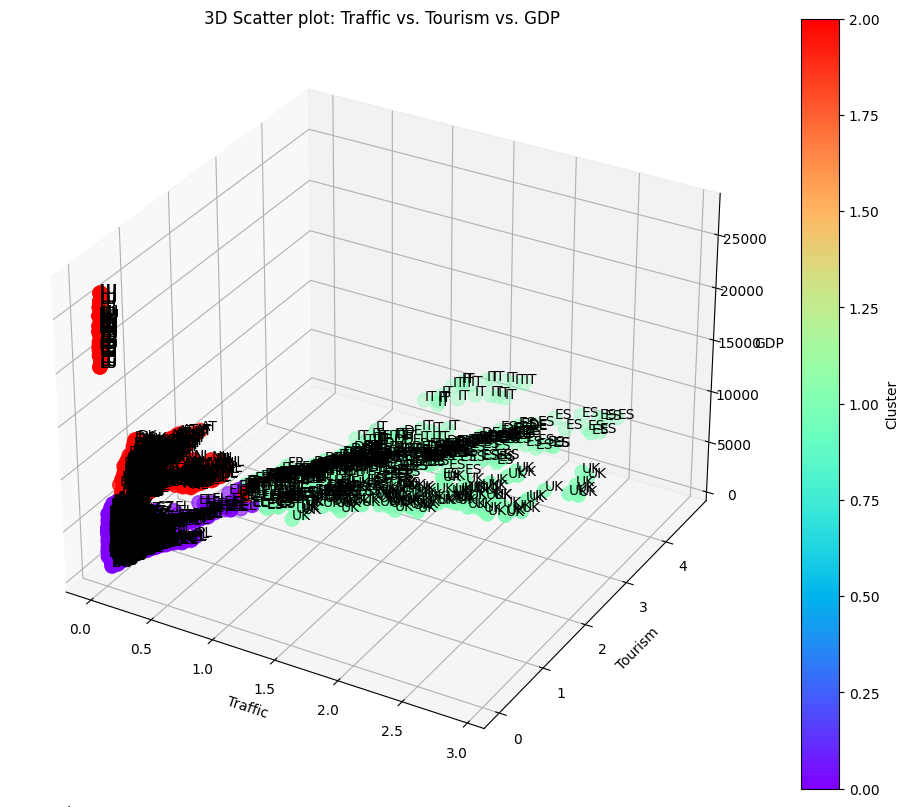

In [39]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(merged_data['Traffic'], merged_data['Tourism'], merged_data['GDP'], c=merged_data['Cluster'], cmap='rainbow', s=100)

for idx, row in merged_data.iterrows():
    ax.text(row['Traffic'], row['Tourism'], row['GDP'], row['geo'])

ax.set_xlabel('Traffic')
ax.set_ylabel('Tourism')
ax.set_zlabel('GDP')
ax.set_title('3D Scatter plot: Traffic vs. Tourism vs. GDP')

fig.colorbar(sc).set_label('Cluster')

plt.show()


In [40]:
def mode_cluster(x):
    mode, _ = stats.mode(x)
    return mode[0]

country_clusters = merged_data.groupby('geo')['Cluster'].apply(mode_cluster).reset_index()
cluster = {}
for cluster_num in range(k):
    print(f"Cluster {cluster_num}: {', '.join(country_clusters[country_clusters['Cluster'] == cluster_num]['geo'].tolist())}")
    cluster[cluster_num] = country_clusters[country_clusters['Cluster'] == cluster_num]['geo'].tolist()

Cluster 0: BG, CY, CZ, EE, EL, HR, HU, LT, LV, MT, PL, PT, RO, SI, SK
Cluster 1: DE, ES, FR, IT, UK
Cluster 2: AT, BE, DK, FI, LU, NL, SE


/var/folders/t7/zv66s7112kz90jccz5_hq3480000gn/T/ipykernel_50097/3170051467.py:2: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



### Boxplot per cluster 

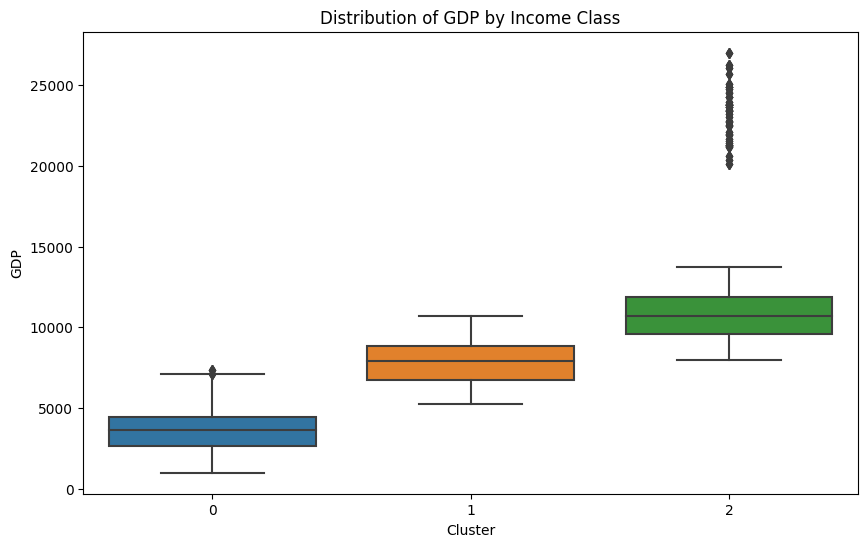

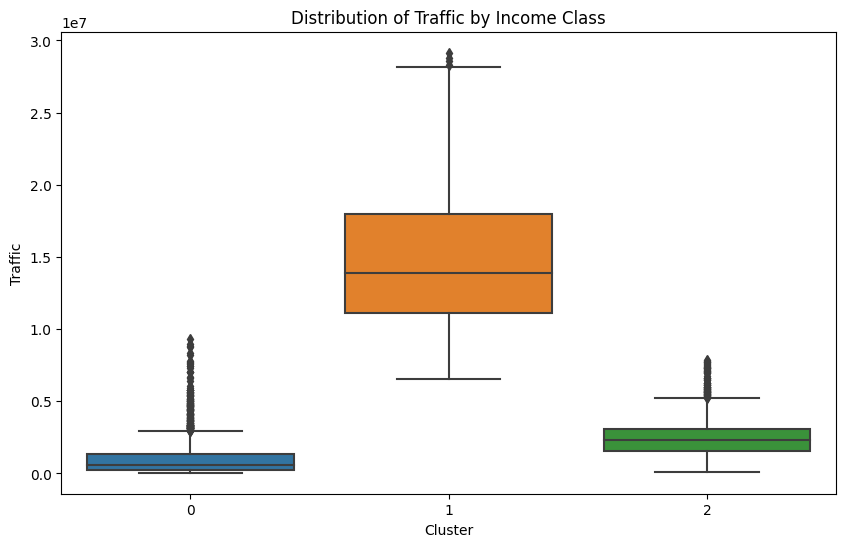

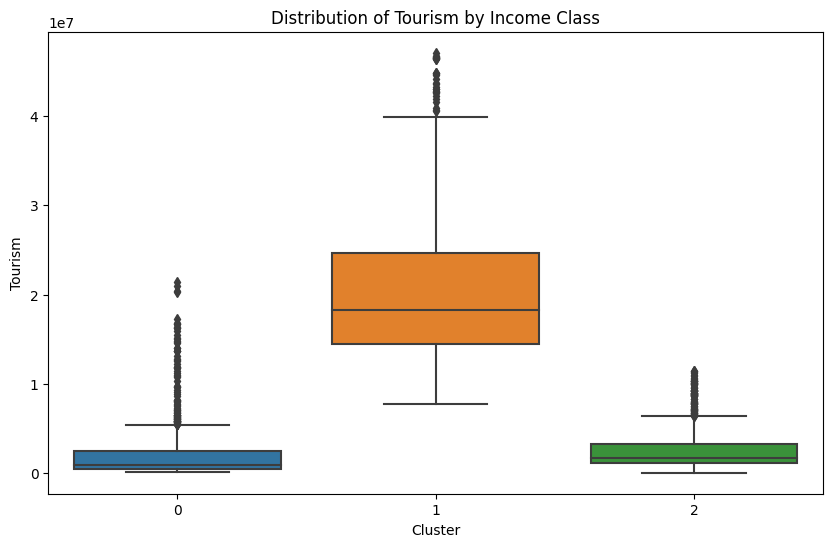

In [44]:
country_to_cluster = {country: cluster for cluster, countries in cluster.items() for country in countries}
merged_data['Income Class'] = merged_data['geo'].map(country_to_cluster)
metrics = ['GDP', 'Traffic', 'Tourism']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Income Class', y=metric, data=merged_data)
    plt.title(f'Distribution of {metric} by Income Class')
    plt.ylabel(metric)
    plt.xlabel('Cluster')
    plt.show()

- Cluster 0 (15 countries): These countries are the smallest in terms of GDP, tourism, and air passengers.

    - GDP: These nations might be developing or have smaller economies in comparison to the other two clusters.
    - Tourism: They have emerging tourist destinations or destinations that might be popular locally or regionally but not as internationally renowned.
    - Air Passengers: They see fewer international passengers, likely due to having fewer international airports or fewer connections to major global hubs.

- Cluster 1 (5 countries): These are the top performers in all three categories, signifying their importance both in Europe and globally.

    - GDP: Being some of the largest economies in Europe, they play a pivotal role in global economic activities.
    - Tourism: These are top tourist destinations, attracting a vast majority of international tourists due to their diverse attractions.
    - Air Passengers: Serving as significant hubs for international travel, these countries likely have multiple major international airports.

- Cluster 2 (7 countries): These countries are in between the other two clusters in all categories, signifying their robust yet not dominant position.

    - GDP: While not as high as Cluster 1, these countries still have strong economies, possibly with a high GDP per capita.
    - Tourism: Catering to both mainstream and niche tourist markets, they have a significant number of tourists but not as much as Cluster 1.
    - Air Passengers: They have good connectivity and might serve as secondary hubs in Europe, but they don't see as much traffic as the countries in Cluster 1.

## Map

In [42]:
import plotly.express as px

fig = px.choropleth(
    merged_data,
    locations='geo',
    locationmode='ISO-3',
    color='GDP',
    hover_name='geo',
    animation_frame='TIME_PERIOD',
    title='GDP of European Countries from 2010 to 2020',
    scope='europe',
    color_continuous_scale=px.colors.sequential.Plasma
)

# Adjust the slider properties
sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 15},
        'prefix': 'Year:',
        'visible': True,
        'xanchor': 'right'
    }
}

fig.update_layout(sliders=[sliders_dict])
fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()


## 5. Conclusion and discussion

some answers:
- *The clustering algorithm can cluster countries based on these factors*
- *There can be seen that luxembourg do not care if lower passengers or tourism, gdp still stays high*
- *The lower income countries can be determined with the kmeans and there can be seen that Italy, Spain, France and Germany indeed need tourism and passengers, can be clearly seen*
- *AT, BE, DK, FI, LU, NL, SE: These are high income classes and are clustered together based on the criteria.*
-  Can be seen that in countries like Bulgaria: the gdp, air passengers and tourism relate to each other, all low and all high. For France, Belgium for example you see that this isnt the story because GDP is relatively lower when tourism and air passengers are relatively higher.

## References